In [1]:
import os
import zipfile
from google.colab import files

# Upload the ZIP file
uploaded = files.upload()

# Extract the ZIP file
for filename in uploaded.keys():
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall("unzipped_folder") # Extract to 'unzipped_folder'

# Verify extraction
print("Files extracted to: ", os.listdir("unzipped_folder"))

# Update extracted_folder with the correct path after examining the contents of "unzipped_folder"
extracted_folder = "unzipped_folder/reddit stocks csv" # Assuming 'reddit stocks csv' is inside "unzipped_folder"

# Check if the folder exists before proceeding.
if os.path.exists(extracted_folder) and os.path.isdir(extracted_folder):
    files_in_folder = os.listdir(extracted_folder)
    print(files_in_folder)
else:
    print(f"Error: Folder '{extracted_folder}' not found. Please check the extracted files.")

Saving reddit stocks csv.zip to reddit stocks csv.zip
Files extracted to:  ['__MACOSX', 'reddit stocks csv']
['reddit_3.csv', 'reddit_7.csv', 'reddit_2.csv', 'reddit_4.csv', 'reddit_5.csv', 'reddit_30.csv', 'reddit_15.csv', 'reddit_9.csv', 'reddit_6.csv', 'reddit_19.csv', 'reddit_12.csv', '.DS_Store', 'reddit_17.csv', 'reddit_25.csv', 'reddit_16.csv', 'reddit_13.csv', 'reddit_11.csv', 'reddit_23.csv', 'reddit_20.csv', 'reddit_28.csv', 'reddit_26.csv', 'reddit_1.csv', 'reddit_10.csv', 'reddit_24.csv', 'reddit_27.csv', 'reddit_22.csv', 'reddit_8.csv', 'reddit_21.csv', 'reddit_29.csv', 'reddit_18.csv', 'reddit_14.csv']


In [2]:
import pandas as pd

# Path to the extracted folder
folder_path = '/content/unzipped_folder/reddit stocks csv'

# List of CSV files in the folder
csv_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# Initialize an empty list to store dataframes
dataframes = []

# Read and append each CSV to the list
for file in csv_files:
    try:
        df = pd.read_csv(file)
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Merge all dataframes
merged_df = pd.concat(dataframes, ignore_index=True)

# Save the merged dataframe
merged_file = 'merged_reddit_stocks.csv'
merged_df.to_csv(merged_file, index=False)

print(f"Merged file saved as: {merged_file}")


Merged file saved as: merged_reddit_stocks.csv


In [40]:
import pandas as pd
import re
from collections import Counter

# Load the processed dataset
file_path = "/content/updated_dataset_with_sentiments.csv"  # Replace with your sentiment-processed file
data = pd.read_csv(file_path)

# Feature 1: Extract stock mentions
def extract_stock_mentions(title):
    stock_symbols = re.findall(r'\$[A-Za-z]+', title)  # Extract stock symbols starting with $
    return stock_symbols

# Add a new column for stock mentions
data['Stock_Mentions'] = data['Title'].apply(extract_stock_mentions)

# Count the frequency of mentions
all_mentions = [symbol for mentions in data['Stock_Mentions'] for symbol in mentions]
mention_counts = Counter(all_mentions)

print("=== Top 10 Mentioned Stocks ===")
top_10_mentions = mention_counts.most_common(10)
for symbol, count in top_10_mentions:
    print(f"{symbol}: {count} mentions")

# Feature 2: Average Sentiment and Post Volume Per Day
# Convert 'Created At' to datetime
# Changed the format string to match the actual date format in your data
data['Date'] = pd.to_datetime(data['Created At'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
# The 'errors='coerce'' argument handles any dates that still don't match by setting them to NaT (Not a Time)

# Calculate average sentiment and post volume per day
daily_sentiment = data.groupby(data['Date'].dt.date).agg(
    Avg_Sentiment=('Sentiment_Polarity', 'mean'),
    Post_Volume=('Title', 'count')
).reset_index()

print("\n=== Daily Sentiment Trends ===")
print(daily_sentiment.head())

# Feature 3: Sentiment Trends by Stock Symbol
def calculate_sentiment_by_symbol(data):
    symbol_sentiment = {}
    for index, row in data.iterrows():
        for symbol in row['Stock_Mentions']:
            if symbol not in symbol_sentiment:
                symbol_sentiment[symbol] = []
            symbol_sentiment[symbol].append(row['Sentiment_Polarity'])
    return {symbol: sum(sentiments)/len(sentiments) for symbol, sentiments in symbol_sentiment.items()}

symbol_sentiment = calculate_sentiment_by_symbol(data)

print("\n=== Sentiment Trend by Stock Symbol ===")
for symbol, avg_sentiment in list(symbol_sentiment.items())[:10]:  # Show only top 10 for brevity
    print(f"{symbol}: Average Sentiment = {avg_sentiment:.2f}")

# Save enriched dataset
output_file = "enriched_dataset_with_features.csv"
data.to_csv(output_file, index=False)

print(f"\nFeature extraction completed. Enriched dataset saved to {output_file}.")

=== Top 10 Mentioned Stocks ===
$SPY: 12 mentions
$SPX: 11 mentions
$AAPL: 8 mentions
$MSFT: 3 mentions
$NVDA: 3 mentions
$PL: 3 mentions
$GME: 3 mentions
$CABA: 2 mentions
$MYNZ: 2 mentions
$RTX: 2 mentions

=== Daily Sentiment Trends ===
         Date  Avg_Sentiment  Post_Volume
0  2020-06-01       0.000000            1
1  2021-02-15       0.357143            1
2  2021-03-26       0.468182            1
3  2021-09-25       0.000000            1
4  2022-03-17       0.000000            1

=== Sentiment Trend by Stock Symbol ===
$CABA: Average Sentiment = 0.00
$BGM: Average Sentiment = -0.05
$AZI: Average Sentiment = 0.80
$MYNZ: Average Sentiment = 0.06
$RTX: Average Sentiment = 0.00
$RDDT: Average Sentiment = 0.03
$EL: Average Sentiment = -0.15
$AKTS: Average Sentiment = 0.35
$MDAI: Average Sentiment = 0.03
$CCO: Average Sentiment = 0.00

Feature extraction completed. Enriched dataset saved to enriched_dataset_with_features.csv.


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [51]:
# Assuming your dataset is in CSV format
df = pd.read_csv('/content/updated_dataset_with_sentiments.csv')


In [53]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Check if the input is a string
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove non-alphabetic characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        # Tokenize and lemmatize
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)
    else:
        # Handle non-string values (e.g., return an empty string or NaN)
        return ''  # Or you could return np.nan

# Apply preprocessing to the Cleaned_Title column
df['Cleaned_Title'] = df['Cleaned_Title'].apply(preprocess_text)

In [54]:
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df['Cleaned_Title'])


In [56]:
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df[['Score', 'Upvote Ratio', 'Total Comments', 'Sentiment_Polarity']])


In [57]:
X = np.hstack([X_text.toarray(), X_numeric])
y = df['Sentiment_Category']  # This should be the target for stock movement (e.g., 'Positive', 'Negative', 'Neutral')


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [59]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='weighted')
recall = recall_score(y_test, y_pred_rf, average='weighted')
f1 = f1_score(y_test, y_pred_rf, average='weighted')
cm = confusion_matrix(y_test, y_pred_rf)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Confusion Matrix:\n {cm}")


Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 Score: 0.98
Confusion Matrix:
 [[ 37   7   0]
 [  0 273   0]
 [  0   0 103]]


In [62]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to your target variable and transform it
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)



In [63]:
# Build a Sequential model
model = Sequential()

# Input layer
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

# Hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Dropout to prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(3, activation='softmax'))  # Assuming three classes (Positive, Neutral, Negative)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predictions on test set
y_pred_nn = model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Evaluate the neural network model
accuracy_nn = accuracy_score(y_test, y_pred_nn_classes)
precision_nn = precision_score(y_test, y_pred_nn_classes, average='weighted')
recall_nn = recall_score(y_test, y_pred_nn_classes, average='weighted')
f1_nn = f1_score(y_test, y_pred_nn_classes, average='weighted')

print(f"Neural Network - Accuracy: {accuracy_nn:.2f}")
print(f"Neural Network - Precision: {precision_nn:.2f}")
print(f"Neural Network - Recall: {recall_nn:.2f}")
print(f"Neural Network - F1 Score: {f1_nn:.2f}")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6200 - loss: 1.0035 - val_accuracy: 0.7649 - val_loss: 0.6634
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8304 - loss: 0.5071 - val_accuracy: 0.8661 - val_loss: 0.3379
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9032 - loss: 0.2112 - val_accuracy: 0.9196 - val_loss: 0.2190
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9772 - loss: 0.0791 - val_accuracy: 0.9435 - val_loss: 0.1814
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9964 - loss: 0.0330 - val_accuracy: 0.9375 - val_loss: 0.2170
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9987 - loss: 0.0148 - val_accuracy: 0.9494 - val_loss: 0.1949
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9986 - loss: 0.0113 - val_accuracy: 0.9494 - val_loss: 0.2066
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9996 - loss: 0.0059 - val_accuracy: 0.9583 - val_loss: 0.

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


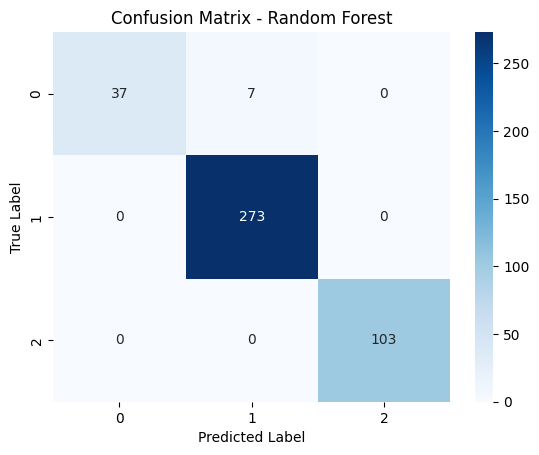

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


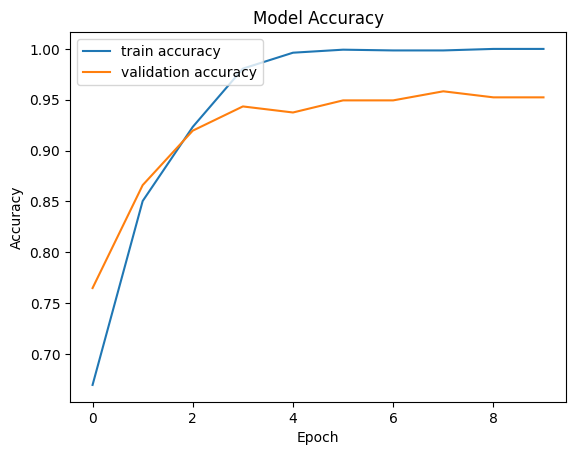

In [66]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


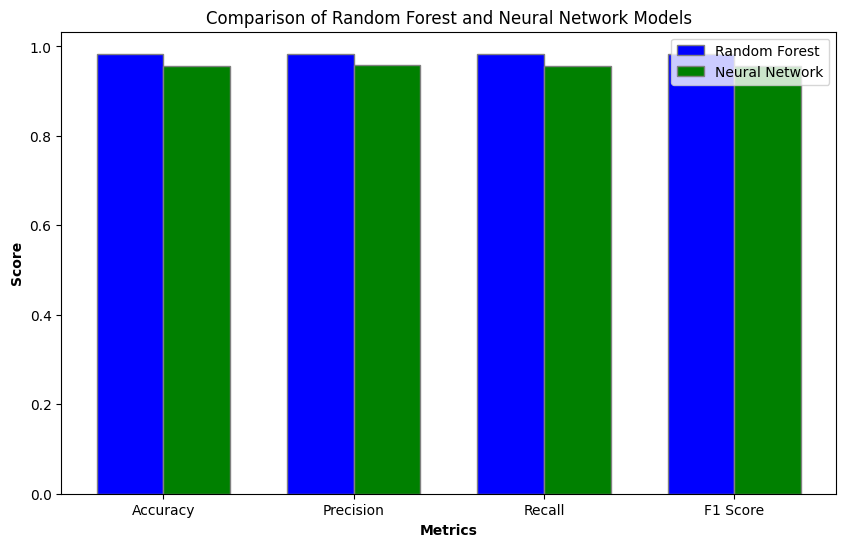

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics for both models
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Random Forest scores
rf_scores = [accuracy, precision, recall, f1]

# Neural Network scores
nn_scores = [accuracy_nn, precision_nn, recall_nn, f1_nn]

# Set the width for bars
bar_width = 0.35

# Set the position of bars
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.figure(figsize=(10, 6))

plt.bar(r1, rf_scores, color='b', width=bar_width, edgecolor='grey', label='Random Forest')
plt.bar(r2, nn_scores, color='g', width=bar_width, edgecolor='grey', label='Neural Network')

# Add labels, title, and axis names
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('Comparison of Random Forest and Neural Network Models')
plt.xticks([r + bar_width / 2 for r in range(len(metrics))], metrics)

# Add a legend
plt.legend()

# Show the plot
plt.show()
